# Imports

In [1]:
# Assumes transformer_lens has been installed, %pip install transformer_lens
from transformer_lens import HookedTransformer
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, pipeline, AutoModelForSequenceClassification
import scipy.stats as st
from typing import List
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.8/174.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    F

# Helper Functions

Model Generation

In [3]:
def hooked_generate(model, prompt_batch: List[str], fwd_hooks=[], generate_length=60):
    """
    Generates new tokens using the given model and prompt batch.

    Args:
        model: The model used for token generation.
        prompt_batch: A list of strings representing the input prompts.
        fwd_hooks: A list of forward hooks to be applied during token generation.
        generate_length: The number of new tokens to generate.

    Returns:
        A list of generated tokens with the original prompt stripped from the beginning.

    """
    with model.hooks(fwd_hooks=fwd_hooks):
        model.tokenizer.padding_side = 'left'
        tokenized = model.to_tokens(prompt_batch)
        r = model.generate(input=tokenized, max_new_tokens=generate_length, do_sample=True, verbose=False, padding_side=None)

    r = model.to_string(r)
    r = [output.replace('<|endoftext|>', '').strip() for output in r]

    stripped_outputs = []
    for output, prompt in zip(r, prompt_batch):
        stripped_output = output[len(prompt):].strip()
        stripped_outputs.append(stripped_output)

    return stripped_outputs

Hooks

In [4]:
def generate_ave_hook_addition(steering_vector, beta):
    """
    Generates a hook function to add a steering vector to the last token.

    Parameters:
    - steering_vector (torch.Tensor): Steering vector.
    - beta (float): Scaling factor.

    Returns:
    - function: Hook function for adding steering vector.
    """
    def last_token_steering_hook(resid_pre, hook):
        for i in range(resid_pre.shape[0]):
            current_token_index = resid_pre.shape[1] - 1
            resid_pre[i, current_token_index, :] += steering_vector.squeeze() * beta

    return last_token_steering_hook

In [5]:
def generate_ave_hook_addition_mean_centered(steering_vector, mean_train, beta):
    """
    Generates a hook function to add a mean-centered steering vector to the last token.

    Parameters:
    - steering_vector (torch.Tensor): Steering vector.
    - mean_train (torch.Tensor): Mean training vector.
    - beta (float): Scaling factor.

    Returns:
    - function: Hook function for adding mean-centered steering vector.
    """
    def last_token_steering_hook(resid_pre, hook):
        for i in range(resid_pre.shape[0]):
            current_token_index = resid_pre.shape[1] - 1
            resid_pre[i, current_token_index, :] += (steering_vector.squeeze() - mean_train) * beta

    return last_token_steering_hook

In [6]:
def generate_conceptor_hook(conceptor, beta):
    """
    Generates a hook function to apply a conceptor to the last token.

    Parameters:
    - conceptor (torch.Tensor): Conceptor matrix.
    - beta (float): Scaling factor.

    Returns:
    - function: Hook function for applying conceptor.
    """
    def last_token_steering_hook(resid_pre, hook):
        for i in range(resid_pre.shape[0]):
            current_token_index = resid_pre.shape[1] - 1
            resid_pre[i, current_token_index, :] = steer(C=conceptor, x=resid_pre[i, current_token_index, :], beta=beta)

    return last_token_steering_hook

In [7]:
def generate_conceptor_hook_mean_centered(conceptor, mean_train, beta):
    """
    Generates a hook function to apply a mean-centered conceptor to the last token.

    Parameters:
    - conceptor (torch.Tensor): Conceptor matrix.
    - mean_train (torch.Tensor): Mean training vector.
    - beta (float): Scaling factor.

    Returns:
    - function: Hook function for applying mean-centered conceptor.
    """
    def last_token_steering_hook(resid_pre, hook):
        for i in range(resid_pre.shape[0]):
            current_token_index = resid_pre.shape[1] - 1
            resid_pre[i, current_token_index, :] = steer(C=conceptor, x=resid_pre[i, current_token_index, :] - mean_train, beta=beta) + mean_train

    return last_token_steering_hook

In [8]:
def steer(C, x, beta):
    """
    Steers the given vector x using the conceptor C.

    Args:
        C (torch.Tensor): The conceptor matrix.
        x (torch.Tensor): The vector to be steered.
        beta (float): The steering parameter with 0: no steering, 1: full steering.

    Returns:
        torch.Tensor: The steered vector.
    """
    C = C.to(torch.float16)
    return beta * torch.matmul(C, x)

Conceptors

In [9]:
def compute_conceptor(X, aperture):
    """
    Compute the conceptor matrix.
    Args:
        X (torch.Tensor): The activations or data matrix.
        aperture (float): The aperture parameter controlling the conceptor.
    Returns:
        torch.Tensor: The conceptor matrix.
    """
    # Convert to float32 for SVD computation
    X_float32 = X.float()
    R = torch.matmul(X_float32.T, X_float32) / X_float32.shape[0]

    # Perform SVD in float32
    U, S, _ = torch.svd(R)

    # Compute the conceptor in float32
    C_float32 = U * (S / (S + (aperture**(-2)) * torch.ones(S.shape, device=U.device))) @ U.T

    # Convert the conceptor back to float16
    C = C_float32.half()
    return C

# Setup

Config

In [10]:
toxic_dataset_path = './Mean_Activation_Vectors/toxic/toxic_texts.pkl'
non_toxic_dataset_path = './Mean_Activation_Vectors/non_toxic/non_toxic_texts.pkl'
loving_dataset_path = './Mean_Activation_Vectors/loving/loving_texts.pkl'
mean_train_activations_path = './Mean_Activation_Vectors/mean_train/mean_train_activations-gpt-2-small.pkl'
loving_mean_activations_path = './Mean_Activation_Vectors/mean_train/loving_mean_activations-gpt2-small.pkl'
loving_activations_path = './Mean_Activation_Vectors/mean_train/loving_activations-gpt2-small.pkl'

Load Datasets

In [11]:
with open(toxic_dataset_path, 'rb') as f:
    toxic_texts = pickle.load(f)

with open(non_toxic_dataset_path, 'rb') as f:
    non_toxic_texts = pickle.load(f)

with open(loving_dataset_path, 'rb') as f:
    loving_texts = pickle.load(f)

with open(mean_train_activations_path, 'rb') as f:
    mean_train_activations = pickle.load(f)

with open(loving_mean_activations_path, 'rb') as f:
    loving_mean_activations = pickle.load(f)

with open(loving_activations_path, 'rb') as f:
    loving_activations = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Model

In [12]:
# Load model onto GPU (if possible)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'gpt2'
DTYPE = 'float16'
NUM_LAYERS = 12

torch.set_grad_enabled(False)
model = HookedTransformer.from_pretrained_no_processing(model_name=MODEL_NAME, device=DEVICE, dtype=DTYPE)
model.eval();

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2 into HookedTransformer


Other Config

In [13]:
# TODO: These are the values to hyperparam sweep
LAYER_INTERVENTION = 8    # Layer of intervention (if it costs a lot of resources then I would only try layers 5-9)
BETA_ADD = 2.3            # Beta for additive (only between 1-4?)
BETA_CON = 3.9            # Beta for conceptor (only between 1-4?)
APERTURE_CON = 0.0125     # Aperture for conceptor (regular)
APERTURE_CON_MC = 0.05    # Aperture for conceptor (mean-centered)

In [14]:
love_vector = loving_mean_activations[LAYER_INTERVENTION]
mean_train = mean_train_activations[LAYER_INTERVENTION]
love_activations = loving_activations[LAYER_INTERVENTION]

# Generate Outputs

Unsteered

In [15]:
unsteered_outputs = hooked_generate(model, toxic_texts, fwd_hooks=[])

Loving Add

In [16]:
love_add_hook = generate_ave_hook_addition(steering_vector=love_vector, beta=BETA_ADD)
love_add_modification = (f"blocks.{LAYER_INTERVENTION}.hook_resid_pre", love_add_hook)
love_add_hooks = [love_add_modification]
love_add_outputs = hooked_generate(model, toxic_texts, fwd_hooks=love_add_hooks)

Loving Add (MC)

In [17]:
love_add_mc_hook = generate_ave_hook_addition_mean_centered(steering_vector=love_vector, mean_train=mean_train, beta=BETA_ADD)
love_add_mc_modification = (f"blocks.{LAYER_INTERVENTION}.hook_resid_pre", love_add_mc_hook)
love_add_mc_hooks = [love_add_mc_modification]
love_add_mc_outputs = hooked_generate(model, toxic_texts, fwd_hooks=love_add_mc_hooks)

Loving Conceptor

In [18]:
love_conceptor = compute_conceptor(love_activations, APERTURE_CON)

love_con_hook = generate_conceptor_hook(conceptor=love_conceptor, beta=BETA_CON)
love_con_modification = (f"blocks.{LAYER_INTERVENTION}.hook_resid_pre", love_con_hook)
love_con_hooks = [love_con_modification]
love_con_outputs = hooked_generate(model, toxic_texts, fwd_hooks=love_con_hooks)

Loving Conceptor (MC)

In [19]:
love_mc_conceptor = compute_conceptor(love_activations - mean_train, APERTURE_CON_MC)

love_con_mc_hook = generate_conceptor_hook_mean_centered(conceptor=love_mc_conceptor, mean_train=mean_train, beta=BETA_CON)
love_con_mc_modification = (f"blocks.{LAYER_INTERVENTION}.hook_resid_pre", love_con_mc_hook)
love_con_mc_hooks = [love_con_mc_modification]
love_con_mc_outputs = hooked_generate(model, toxic_texts, fwd_hooks=love_con_mc_hooks)

# Positive Sentiment Analysis

Sentiment Computation

In [ ]:
# Initialize the tokenizer and sentiment analysis pipeline
tokenizer = model.tokenizer
device = 0 if torch.cuda.is_available() else -1
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=device)

# Function to calculate sentiment for each token step
def compute_sentiments(texts):
    max_length = max([len(tokenizer.tokenize(text)) for text in texts])
    padded_sentiments = np.full((len(texts), max_length), np.nan)

    for idx, text in enumerate(texts):
        tokens = tokenizer.tokenize(text)
        sentiments = []

        for i in range(1, len(tokens) + 1):
            subsequence = tokenizer.convert_tokens_to_string(tokens[:i])
            sentiment_result = sentiment_pipeline(subsequence)[0]
            score = sentiment_result['score'] if sentiment_result['label'] == 'POSITIVE' else 1 - sentiment_result['score']
            sentiments.append(score)

        padded_sentiments[idx, :len(sentiments)] = sentiments

    mean_sentiments = np.nanmean(padded_sentiments, axis=0)
    ci_bounds = st.t.interval(0.95, len(texts) - 1, loc=mean_sentiments, scale=st.sem(padded_sentiments, axis=0, nan_policy='omit'))

    return mean_sentiments, ci_bounds, max_length

# Compute sentiments for each output type
mean_unsteered_sentiments, ci_unsteered_bounds, max_length_unsteered = compute_sentiments(unsteered_outputs)
mean_love_add_sentiments, ci_love_add_bounds, max_length_love_add = compute_sentiments(love_add_outputs)
mean_love_add_mc_sentiments, ci_love_add_mc_bounds, max_length_love_add_mc = compute_sentiments(love_add_mc_outputs)
mean_love_con_sentiments, ci_love_con_bounds, max_length_love_con = compute_sentiments(love_con_outputs)
mean_love_con_mc_sentiments, ci_love_con_mc_bounds, max_length_love_con_mc = compute_sentiments(love_con_mc_outputs)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Plotting

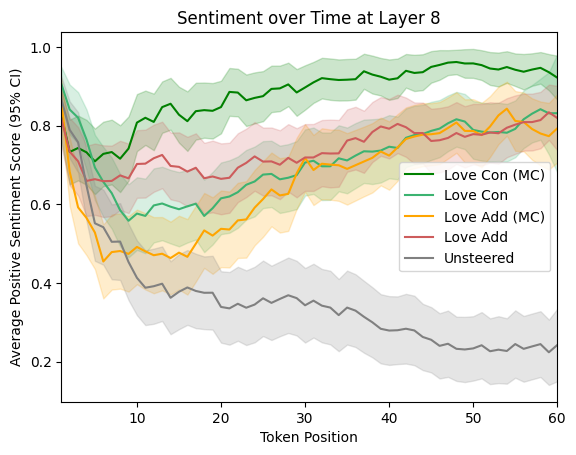

In [21]:
# Calculate the overall final position (capped at 60 tokens)
final_position = min(max_length_unsteered, max_length_love_add, max_length_love_add_mc, max_length_love_con, max_length_love_con_mc, 60)

# Function to plot sentiments
def plot_sentiments(x_values, mean_sentiments, ci_bounds, label, color, final_position):
    plt.plot(x_values[:final_position], mean_sentiments[:final_position], label=label, color=color)
    plt.fill_between(x_values[:final_position], ci_bounds[0][:final_position], ci_bounds[1][:final_position], color=color, alpha=0.2)

# Generate x_values for plotting
x_values = np.arange(1, final_position + 1)

# Plot each sentiment line using the overall final position
plot_sentiments(x_values, mean_love_con_mc_sentiments, ci_love_con_mc_bounds, 'Love Con (MC)', 'green', final_position)
plot_sentiments(x_values, mean_love_con_sentiments, ci_love_con_bounds, 'Love Con', 'mediumseagreen', final_position)
plot_sentiments(x_values, mean_love_add_mc_sentiments, ci_love_add_mc_bounds, 'Love Add (MC)', 'orange', final_position)
plot_sentiments(x_values, mean_love_add_sentiments, ci_love_add_bounds, 'Love Add', 'indianred', final_position)
plot_sentiments(x_values, mean_unsteered_sentiments, ci_unsteered_bounds, 'Unsteered', 'grey', final_position)

# Set the x-axis limits to restrict the plot to the intended range
plt.xlim(1, final_position)

# Finalize the plot
plt.xlabel('Token Position')
plt.ylabel('Average Positive Sentiment Score (95% CI)')
plt.title(f'Sentiment over Time at Layer {LAYER_INTERVENTION}')
plt.grid(False)
plt.legend()
plt.show()


# Toxicity Analysis

Toxicity Computation

In [22]:
# Load the toxicity model
tokenizer_toxicity = AutoTokenizer.from_pretrained("unitary/unbiased-toxic-roberta")
model_toxicity = AutoModelForSequenceClassification.from_pretrained("unitary/unbiased-toxic-roberta")
toxicity_pipeline = pipeline("text-classification", model=model_toxicity, tokenizer=tokenizer_toxicity, device=0 if torch.cuda.is_available() else -1, top_k=None)

# Function to compute negative toxicity log-probabilities
def compute_negative_toxicity_log_probabilities(texts):
    log_probs = []
    for text in texts:
        outputs = toxicity_pipeline(text)

        toxic_probs = [score['score'] for score in outputs[0] if 'toxic' in score['label'].lower()]

        if toxic_probs:
            log_prob = np.log(toxic_probs[0])
            log_probs.append(-log_prob)  # Negative log-probability
        else:
            # Handle the case where 'TOXIC' label is not found
            log_probs.append(np.nan)

    return log_probs

unsteered_log_probs = compute_negative_toxicity_log_probabilities(unsteered_outputs)
love_add_log_probs = compute_negative_toxicity_log_probabilities(love_add_outputs)
love_add_mc_log_probs = compute_negative_toxicity_log_probabilities(love_add_mc_outputs)
love_con_log_probs = compute_negative_toxicity_log_probabilities(love_con_outputs)
love_con_mc_log_probs = compute_negative_toxicity_log_probabilities(love_con_mc_outputs)

tokenizer_config.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Plotting

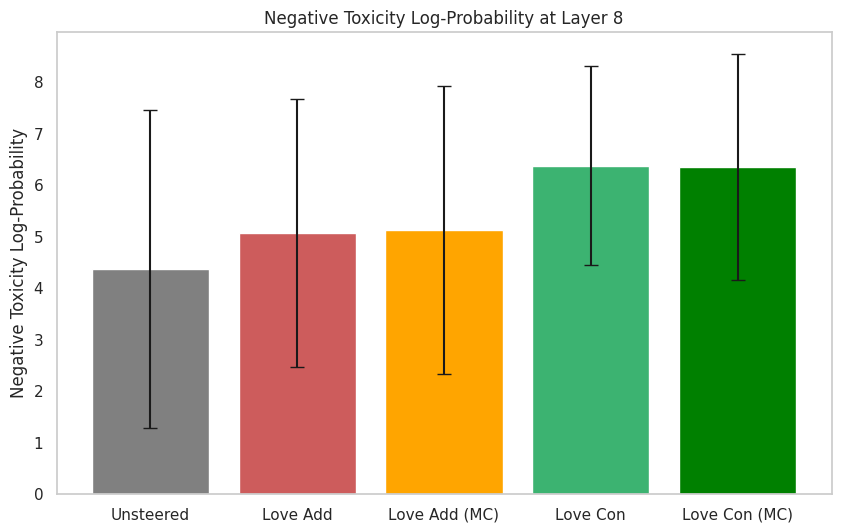

In [23]:
labels = ['Unsteered', 'Love Add', 'Love Add (MC)', 'Love Con', 'Love Con (MC)']
data = [
    np.mean(unsteered_log_probs),
    np.mean(love_add_log_probs),
    np.mean(love_add_mc_log_probs),
    np.mean(love_con_log_probs),
    np.mean(love_con_mc_log_probs)
]
errors = [
    np.std(unsteered_log_probs),
    np.std(love_add_log_probs),
    np.std(love_add_mc_log_probs),
    np.std(love_con_log_probs),
    np.std(love_con_mc_log_probs)
]

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

barplot = plt.bar(labels, data, yerr=errors, capsize=5, color=['grey', 'indianred', 'orange', 'mediumseagreen', 'green'])

plt.grid(False)

plt.ylabel('Negative Toxicity Log-Probability')
plt.title('Negative Toxicity Log-Probability at Layer 8')

plt.show()